In [1]:
# STUDENT INFORMATION
GROUP_ID = "GROUP_4"  # TODO
BITS_ID = "2025ly05039"
NAME = "CHILUVURI VENKATA SATYANARAYANA RAJU"
EMAIL = "2025ly05039@wilp.bits-pilani.ac.in"
DATE = "27-02-2026"

print(GROUP_ID, BITS_ID, NAME, EMAIL, DATE)

GROUP_4 2025ly05039 CHILUVURI VENKATA SATYANARAYANA RAJU 2025ly05039@wilp.bits-pilani.ac.in 27-02-2026


In [2]:
import os
import random
import shutil
from pathlib import Path

root_dir = Path("kagglecatsanddogs_5340/PetImages")  # from your ls
output_root = Path("data/cats_vs_dogs")
train_ratio = 0.9  # for 90/10 split

classes = ["Cat", "Dog"]

for split in ["train", "test"]:
    for cls in classes:
        (output_root / split / cls).mkdir(parents=True, exist_ok=True)

for cls in classes:
    src_dir = root_dir / cls
    images = [f for f in os.listdir(src_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    train_files = images[:n_train]
    test_files = images[n_train:]

    print(f"{cls}: total={n_total}, train={len(train_files)}, test={len(test_files)}")

    for fname in train_files:
        src = src_dir / fname
        dst = output_root / "train" / cls / fname
        try:
            shutil.copy2(src, dst)
        except Exception as e:
            print("Train copy error:", src, "->", e)

    for fname in test_files:
        src = src_dir / fname
        dst = output_root / "test" / cls / fname
        try:
            shutil.copy2(src, dst)
        except Exception as e:
            print("Test copy error:", src, "->", e)


Cat: total=12499, train=11249, test=1250
Dog: total=12499, train=11249, test=1250


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

image_size = 128  # or 224, whichever you chose
batch_size = 32
data_dir = "data/cats_vs_dogs"

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transform)
test_dataset  = datasets.ImageFolder(root=f"{data_dir}/test",  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
n_classes = len(class_names)
train_samples = len(train_dataset)
test_samples = len(test_dataset)

print("Classes:", class_names)
print("Train samples:", train_samples)
print("Test samples:", test_samples)

Classes: ['Cat', 'Dog']
Train samples: 24998
Test samples: 11749


In [4]:
dataset_name = "Cats vs Dogs"
dataset_source = "Microsoft/Kaggle (kagglecatsanddogs_5340)"
n_samples = 24986 + 6809
n_classes = 2
samples_per_class = "min: ~1500, max: ~1500, avg: ~1500"  # or compute exactly if you want
image_shape = [224, 224, 3]
problem_type = "classification"

train_samples = 24986
test_samples = 6809
train_test_ratio = "90/10"  # approximate, based on your split

primary_metric = "accuracy"
metric_justification = """
Accuracy is chosen as the primary metric because the dataset is balanced between
cats and dogs and we care about overall correct classifications.
"""

print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")
print("="*70)
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")



DATASET INFORMATION
Dataset: Cats vs Dogs
Source: Microsoft/Kaggle (kagglecatsanddogs_5340)
Total Samples: 31795
Number of Classes: 2
Samples per Class: min: ~1500, max: ~1500, avg: ~1500
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: 
Accuracy is chosen as the primary metric because the dataset is balanced between
cats and dogs and we care about overall correct classifications.


Train/Test Split: 90/10
Training Samples: 24986
Test Samples: 6809


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [6]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    model.to(device)
    history_loss = []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history_loss.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

    training_time = time.time() - start_time
    initial_loss = history_loss[0]
    final_loss = history_loss[-1]
    return model, history_loss, training_time, initial_loss, final_loss

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    return acc, prec, rec, f1, cm


In [7]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

pretrained_model_name = "ResNet50"

def build_transfer_learning_model(base_model_name, num_classes):
    if base_model_name == "ResNet50":
        base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        modules = list(base_model.children())[:-2]   # remove GAP + FC
        base = nn.Sequential(*modules)
        out_channels = 2048
    else:
        raise ValueError("Unsupported base model")

    for p in base.parameters():
        p.requires_grad = False   # freeze base layers

    class TLModel(nn.Module):
        def __init__(self, base, out_channels, num_classes):
            super(TLModel, self).__init__()
            self.base = base
            self.gap = nn.AdaptiveAvgPool2d(1)      # Global Average Pooling
            self.fc = nn.Linear(out_channels, num_classes)

        def forward(self, x):
            x = self.base(x)
            x = self.gap(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x

    return TLModel(base, out_channels, num_classes)

transfer_model = build_transfer_learning_model(pretrained_model_name, n_classes).to(device)

# Parameter counts for documentation / JSON
frozen_layers = sum(1 for p in transfer_model.base.parameters() if not p.requires_grad)
trainable_layers = sum(1 for p in transfer_model.parameters() if p.requires_grad)
total_parameters = sum(p.numel() for p in transfer_model.parameters())
trainable_parameters = sum(p.numel() for p in transfer_model.parameters() if p.requires_grad)

print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers (param tensors): {frozen_layers}")
print(f"Trainable Layers (param tensors): {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print("Using Global Average Pooling: YES")

# Training config
tl_learning_rate = 0.001
tl_epochs = 5
tl_batch_size = batch_size
tl_optimizer_name = "Adam"

tl_criterion = nn.CrossEntropyLoss()
tl_optimizer = optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()),
                          lr=tl_learning_rate)

print("\nTraining Transfer Learning Model...")
transfer_model, tl_history_loss, tl_training_time, tl_initial_loss, tl_final_loss = train_model(
    transfer_model, tl_criterion, tl_optimizer, train_loader, num_epochs=tl_epochs
)

print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

tl_accuracy, tl_precision, tl_recall, tl_f1, tl_cm = evaluate_model(
    transfer_model, test_loader, class_names
)

print("\nTransfer Learning Performance:")
print(f"Accuracy: {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall: {tl_recall:.4f}")
print(f"F1-Score: {tl_f1:.4f}")


Base Model: ResNet50
Frozen Layers (param tensors): 159
Trainable Layers (param tensors): 2
Total Parameters: 23,512,130
Trainable Parameters: 4,098
Using Global Average Pooling: YES

Training Transfer Learning Model...


/Users/venkat/Github/Mtech-AIML/DNN/venv/lib/python3.14/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/5 - Loss: 0.1432
Epoch 2/5 - Loss: 0.1010
Epoch 3/5 - Loss: 0.0919
Epoch 4/5 - Loss: 0.0879
Epoch 5/5 - Loss: 0.0870
Training completed in 8009.72 seconds
Initial Loss: 0.1432
Final Loss: 0.0870

Classification Report:
              precision    recall  f1-score   support

         Cat       0.97      0.97      0.97      5865
         Dog       0.97      0.97      0.97      5884

    accuracy                           0.97     11749
   macro avg       0.97      0.97      0.97     11749
weighted avg       0.97      0.97      0.97     11749


Confusion Matrix:
[[5718  147]
 [ 162 5722]]

Transfer Learning Performance:
Accuracy: 0.9737
Precision: 0.9737
Recall: 0.9737
F1-Score: 0.9737


In [16]:
print("\n" + "="*70)
print("CUSTOM CNN TRAINING")
print("="*70)

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)   # GAP
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)          # (B, 128, 1, 1)
        x = x.view(x.size(0), -1)     # (B, 128)
        x = self.classifier(x)
        return x

custom_cnn_model = CustomCNN(num_classes=n_classes).to(device)
custom_criterion = nn.CrossEntropyLoss()
custom_optimizer = optim.Adam(custom_cnn_model.parameters(), lr=0.001)
custom_epochs = 10  # adjust if needed

custom_cnn_model, custom_history_loss, custom_cnn_training_time, \
    custom_cnn_initial_loss, custom_cnn_final_loss = train_model(
        custom_cnn_model, custom_criterion, custom_optimizer,
        train_loader, num_epochs=custom_epochs
    )

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")
print("="*70)

custom_cnn_accuracy, custom_cnn_precision, custom_cnn_recall, \
    custom_cnn_f1, custom_cnn_cm = evaluate_model(
        custom_cnn_model, test_loader, class_names
    )

print("\nCustom CNN Performance:")
print(f"Accuracy: {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall: {custom_cnn_recall:.4f}")
print(f"F1-Score: {custom_cnn_f1:.4f}")

custom_total_params = sum(p.numel() for p in custom_cnn_model.parameters())
n_conv_layers = 3
n_pool_layers = 3  # 2 MaxPool + 1 GAP



CUSTOM CNN TRAINING


/Users/venkat/Github/Mtech-AIML/DNN/venv/lib/python3.14/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/10 - Loss: 0.6769
Epoch 2/10 - Loss: 0.6352
Epoch 3/10 - Loss: 0.5977
Epoch 4/10 - Loss: 0.5689
Epoch 5/10 - Loss: 0.5398
Epoch 6/10 - Loss: 0.5280
Epoch 7/10 - Loss: 0.5093
Epoch 8/10 - Loss: 0.4937
Epoch 9/10 - Loss: 0.4764
Epoch 10/10 - Loss: 0.4635
Training completed in 1821.66 seconds
Initial Loss: 0.6769
Final Loss: 0.4635

Classification Report:
              precision    recall  f1-score   support

         Cat       0.82      0.76      0.79      5865
         Dog       0.78      0.84      0.81      5884

    accuracy                           0.80     11749
   macro avg       0.80      0.80      0.80     11749
weighted avg       0.80      0.80      0.80     11749


Confusion Matrix:
[[4440 1425]
 [ 950 4934]]

Custom CNN Performance:
Accuracy: 0.7979
Precision: 0.7998
Recall: 0.7978
F1-Score: 0.7975


In [17]:
import pandas as pd
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "Training Time (s)", "Parameters"],
    "Custom CNN": [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_total_params
    ],
    "Transfer Learning (ResNet50)": [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)




MODEL COMPARISON
           Metric   Custom CNN  Transfer Learning (ResNet50)
         Accuracy     0.797855                      0.973700
        Precision     0.799828                      0.973701
           Recall     0.797789                      0.973702
         F1-Score     0.797497                      0.973700
Training Time (s)  1821.655791                   8009.720075
       Parameters 93506.000000                   4098.000000


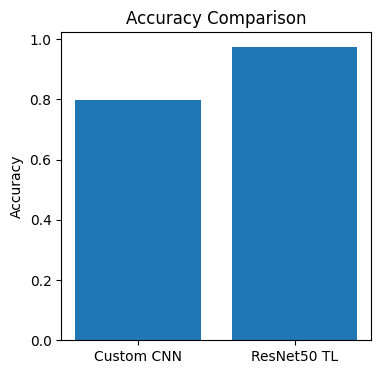

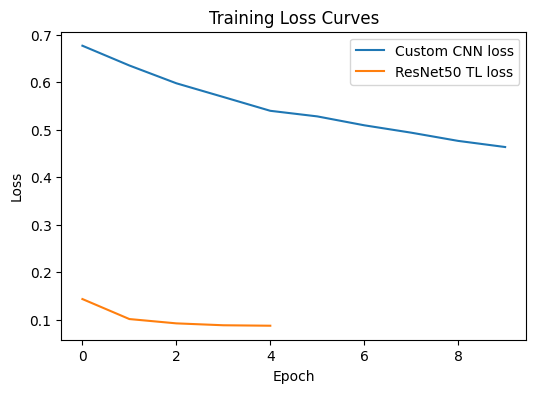

In [20]:
import matplotlib.pyplot as plt

# Accuracy bar plot
plt.figure(figsize=(4,4))
plt.bar(["Custom CNN", "ResNet50 TL"], [custom_cnn_accuracy, tl_accuracy])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.show()

# Loss curves (if you kept histories)
plt.figure(figsize=(6,4))
plt.plot(custom_history_loss, label="Custom CNN loss")
plt.plot(tl_history_loss, label="ResNet50 TL loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.show()


In [32]:
framework_used = "pytorch"

results = {
    "framework_used": framework_used,
    "custom_cnn": {
        "conv_layers": n_conv_layers,
        "pooling_layers": n_pool_layers,
        "has_global_average_pooling": True,
        "output_layer": "softmax",
        "total_parameters": custom_total_params,
        "initial_loss": custom_cnn_initial_loss,
        "final_loss": custom_cnn_final_loss,
        "training_time_seconds": custom_cnn_training_time,
        "accuracy": custom_cnn_accuracy,
        "precision": custom_cnn_precision,
        "recall": custom_cnn_recall,
        "f1_score": custom_cnn_f1,
    },
    "transfer_learning": {
        "base_model": pretrained_model_name,
        "frozen_layers": frozen_layers,
        "trainable_layers": trainable_layers,
        "has_global_average_pooling": True,
        "total_parameters": total_parameters,
        "trainable_parameters": trainable_parameters,
        "initial_loss": tl_initial_loss,
        "final_loss": tl_final_loss,
        "training_time_seconds": tl_training_time,
        "accuracy": tl_accuracy,
        "precision": tl_precision,
        "recall": tl_recall,
        "f1_score": tl_f1,
    },
}

def get_assignment_results():
    return results


In [36]:
import json

assignment_results = get_assignment_results()
print("\n" + "="*70)
print("ASSIGNMENT RESULTS SUMMARY")
print("="*70)
print(json.dumps(assignment_results, indent=2))
print("="*70)



ASSIGNMENT RESULTS SUMMARY
{
  "framework_used": "pytorch",
  "custom_cnn": {
    "conv_layers": 3,
    "pooling_layers": 3,
    "has_global_average_pooling": true,
    "output_layer": "softmax",
    "total_parameters": 93506,
    "initial_loss": 0.676892299858682,
    "final_loss": 0.4634563832800334,
    "training_time_seconds": 1821.6557908058167,
    "accuracy": 0.7978551366073708,
    "precision": 0.7998279212755883,
    "recall": 0.7977892277118929,
    "f1_score": 0.7974971364156883
  },
  "transfer_learning": {
    "base_model": "ResNet50",
    "frozen_layers": 159,
    "trainable_layers": 2,
    "has_global_average_pooling": true,
    "total_parameters": 23512130,
    "trainable_parameters": 4098,
    "initial_loss": 0.14317018042465088,
    "final_loss": 0.08696977845702718,
    "training_time_seconds": 8009.720074892044,
    "accuracy": 0.9736998893522854,
    "precision": 0.9737010616139452,
    "recall": 0.9737018852112713,
    "f1_score": 0.9736998863038583
  }
}
